In [1]:
# %load_ext autoreload
# %autoreload 1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "0"

import torch
from torch import nn
from einops.layers.torch import Rearrange
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import io
import wandb
from keys import load_env

from src.utils.data_loader import FlowGeneratorExperimental
from src.utils.data_loader_strategy import DataFactoryStrategy,BatchReaderStrategyProt
from src.utils.utils import MultipartDownloader,normalize_image,load_cfg
from utilities.segmentation_utils.constants import (
    FileType,
    ImageOrdering,
)
from utilities.segmentation_utils.ImagePreprocessor import PreprocessingQueue
from src.dinov2.trainer import DINOv2Trainer
from src.dinov2.models.dinov2_model import SSLMetaArch,SSLMetaArchHSI
import src.dinov2.distributed as distributed 

from src.utils.metrics import Loss,Accuracy


/notebooks/src/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/notebooks/src/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/notebooks/src/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [2]:
from platform import python_version

print(python_version())
print(torch.cuda.is_available())

load_env()


3.10.13
True


In [3]:
wandb.login()

wandb: Currently logged in as: abodrogai (land-seg). Use `wandb login --relogin` to force relogin


True

In [4]:
distributed.enable(overwrite=True)

In [5]:
ARCHIVE_TRAIN_DATA_PATH = os.path.join("archive", "train")
ARCHIVE_VAL_DATA_PATH = os.path.join("archive", "val")
ARCHIVE_TEST_DATA_PATH = os.path.join("archive", "test")

MODEL_ITERATION = 6
MODEL_NAME = "unknown"
MODEL_FOLDER = "exported_models"
MODEL_LIBRARY = "models"

DATASET = os.path.join("pretrain_dataset")

TRAINING_DATA_PATH = "bchsi/pb_tr/"
VALIDATION_DATA_PATH = "bchsi/pb_val/"
TEST_DATA_PATH = os.path.join("/datasets", DATASET, "e_ts")

NUM_CLASSES = 25

LABEL_MAP = {
    1: np.array([190, 210, 255]),
    2: np.array([0, 255, 197]),
    3: np.array([38, 115, 0]),
    4: np.array([163, 255, 115]),
    5: np.array([76, 230, 0]),
    6: np.array([85, 255, 0]),
    7: np.array([115, 115, 0]),
    8: np.array([168, 168, 0]),
    9: np.array([255, 255, 0]),
    10: np.array([115, 178, 255]),
    11: np.array([0, 92, 230]),
    12: np.array([0, 38, 115]),
    13: np.array([122, 142, 245]),
    14: np.array([0, 168, 132]),
    15: np.array([115, 0, 0]),
    16: np.array([255, 127, 127]),
    17: np.array([255, 190, 190]),
    18: np.array([255, 190, 232]),
    19: np.array([255, 0, 197]),
    20: np.array([230, 0, 169]),
    21: np.array([168, 0, 132]),
    22: np.array([115, 0, 76]),
    23: np.array([255, 115, 223]),
    24: np.array([161, 161, 161]),
    0: np.array([0, 0, 0])
}


mean_per_band = np.array([
    136.43702139, 136.95781982, 136.70735693, 136.91850906, 137.12465157,
    137.26050865, 137.37743316, 137.24835798, 137.04779119, 136.9453704,
    136.79646442, 136.68328908, 136.28231996, 136.02395119, 136.01146934,
    136.72767901, 137.38975674, 137.58604882, 137.61197314, 137.46675538,
    137.57319831, 137.69239868, 137.72318172, 137.76894864, 137.74861655,
    137.77535075, 137.80038781, 137.85482571, 137.88595859, 137.9490434,
    138.00128494, 138.17846624
])
std_per_band = np.array([
    33.48886853, 33.22482796, 33.4670978,  33.53758141, 33.48675988, 33.33348355,
    33.35096189, 33.63958817, 33.85081288, 34.08314358, 34.37542553, 34.60344274,
    34.80732573, 35.17761688, 35.1956623,  34.43121367, 33.76600779, 33.77061146,
    33.92844916, 34.0370747,  34.0285642,  33.87601205, 33.81035869, 33.66611756,
    33.74440912, 33.69755911, 33.69845938, 33.6707364,  33.62571536, 33.44615438,
    33.27907802, 32.90732107
])

In [6]:
cfg = load_cfg()

In [7]:
HPARAMS = {
    'mini_batch_size': 32,
    'batch_size': 256,
    'epoch': 30,
    'criterion':nn.MSELoss,
    'optimizer': torch.optim.Adam,
    'optimizer_params': {
        'lr': 0.0001,
    },

    # loader parameters
    'shuffle': True,
    'preprocess': True,

    # model paramters
    "model_parameters":{
        "patch_size": 8,
        #encoder specific params
        "embed_dim": 768,
        # "depth": 12,
        # "num_heads": 12,
        #decoder specific params
        "decoder_embed_dim":512,
        "decoder_depth": 8,
        "decoder_num_heads": 16,
        "mlp_ratio": 4,
    },
    
    "io_params": {
        "input_size": (64,64),
        "bands": 32,
        "output_size": (64,64),
        "num_classes": NUM_CLASSES,
    },
}

In [8]:
in_queue = PreprocessingQueue(
    [
        # PreFunction(random_flip_up_down),
        # PreFunction(random_flip_left_right),
        # PreFunction(random_crop_and_resize, max_crop_percent=40.0, output_size=HPARAMS['io_params']['input_size']),
        # PreFunction(normalize_image, mean=mean_per_band, std=std_per_band),
    ],
)

val_queue = PreprocessingQueue(
    [
        # PreFunction(normalize_image, mean=mean_per_band, std=std_per_band),
    ],   
)


In [9]:
X_train = BatchReaderStrategyProt(
    os.path.join(TRAINING_DATA_PATH, "image"),
    image_size=HPARAMS['io_params']['input_size'],
)

y_train = BatchReaderStrategyProt(
    os.path.join(TRAINING_DATA_PATH, "image"),
    image_size=HPARAMS['io_params']['output_size'],
)

X_val = BatchReaderStrategyProt(
    os.path.join(VALIDATION_DATA_PATH, "image"),
    image_size=HPARAMS['io_params']['input_size'],
)

batch_reader = DataFactoryStrategy(X_train)

batch_reader_val = DataFactoryStrategy(X_val)

reader_args = {
    "input_strategy": batch_reader,
    "output_strategy": batch_reader,
    "shuffle": HPARAMS["shuffle"],
    "preprocessing_enabled": HPARAMS["preprocess"],
    "channel_mask": [True for _ in range(32)],
    "num_classes": NUM_CLASSES,
    "batch_size": HPARAMS["batch_size"],
    "image_ordering": ImageOrdering.CHANNEL_FIRST,
    "type": [FileType.MULTICHANNEL, FileType.MULTICHANNEL],
    "preprocessing_queue_image": in_queue,
    "preprocessing_queue_mask": in_queue,
}

val_reader_args = {
    "input_strategy": batch_reader_val,
    "output_strategy": batch_reader_val,
    "shuffle": False,
    "preprocessing_enabled": True,
    "channel_mask": [True for _ in range(32)],
    "num_classes": NUM_CLASSES,
    "batch_size": HPARAMS["batch_size"],
    "image_ordering": ImageOrdering.CHANNEL_FIRST,
    "type": [FileType.MULTICHANNEL, FileType.MULTICHANNEL],
    "preprocessing_queue_image": val_queue,
    "preprocessing_queue_mask": val_queue,
}


reader = FlowGeneratorExperimental(**reader_args)
val_reader = FlowGeneratorExperimental(**val_reader_args)
reader.set_mini_batch_size(HPARAMS["mini_batch_size"])
val_reader.set_mini_batch_size(HPARAMS["mini_batch_size"])


Reading from path: bchsi/pb_tr/info.csv
Reading from path: bchsi/pb_tr/info.csv
Reading from path: bchsi/pb_val/info.csv


In [10]:
def load_weigths_to_model(model,weights):
    # load the weights from the checkpoint into the model
    new_state_dict = model.state_dict()
    print(new_state_dict.keys())
    old_state_dict = torch.load(weights)
    print(old_state_dict.keys())
    for name, param in old_state_dict.items():
        if name in new_state_dict and param.size() == new_state_dict[name].size():
            print("Loading layer: ", name)
            new_state_dict[name].copy_(param)
            param.requires_grad = False
        else:
            # Handle layers that do not match or additional processing if required
            print(f"Skipping layer: {name}, as it's not present or mismatched in the new model")
            print(param.size(), new_state_dict[name].size())
            
    
    # Load the modified state dict into the new model
    model.load_state_dict(new_state_dict, strict=False)
    return model    
    

In [11]:
Dino2ModelHandler = SSLMetaArchHSI(cfg)
print(cfg.student.num_register_tokens)

total_params = sum(p.numel() for p in Dino2ModelHandler.parameters())
print(f'{total_params:,} total parameters.')
print(f"Separate sizes:\n\tTeacher: {sum(p.numel() for p in Dino2ModelHandler.teacher.parameters()):,}\n\tStudent: {sum(p.numel() for p in Dino2ModelHandler.student.parameters()):,}")

using SwiGLU layer as FFN
using SwiGLU layer as FFN
4
405,881,120 total parameters.
Separate sizes:
	Teacher: 202,940,560
	Student: 202,940,560


In [12]:
optim = torch.optim.AdamW(Dino2ModelHandler.get_params_groups(), betas=(cfg.optim.adamw_beta1, cfg.optim.adamw_beta2))
dino_trainer = DINOv2Trainer(
    cfg=cfg,
    model=Dino2ModelHandler,
    optimizer=optim,
    criterion=None,
    train_loader=reader,
    device=torch.device("cuda:0"),
    validation_loader=val_reader,
)

wrapped backbone with FSDP: <class 'torch.distributed.fsdp.fully_sharded_data_parallel.FullyShardedDataParallel'>
wrapped dino_head with FSDP: <class 'torch.distributed.fsdp.fully_sharded_data_parallel.FullyShardedDataParallel'>
type(self.student):  <class 'torch.nn.modules.container.ModuleDict'>
FSDP -- models synchronized across GPUs
Global size: 1
LR: 2.5e-05


In [13]:
from torch.distributed.fsdp import FullyShardedDataParallel as FSDP

def print_fsdp_wrapped_modules(module, module_name=''):
    """
    Recursively prints out the module hierarchy and indicates which modules are wrapped with FSDP.
    
    Args:
    - module (torch.nn.Module): The current module to inspect.
    - module_name (str): The name of the current module (for printing purposes).
    """
    is_fsdp = isinstance(module, FSDP)
    print(f"{module_name}: {'FSDP Wrapped' if is_fsdp else 'Not Wrapped'}")
    
    # If it's an FSDP module, you might want to inspect the wrapped module instead
    if is_fsdp:
        module = module.module
    
    for name, child in module.named_children():
        if module_name:
            new_name = f"{module_name}.{name}"
        else:
            new_name = name
        print_fsdp_wrapped_modules(child, new_name)

# Example usage:
# Assuming `model` is your top-level model that may contain FSDP-wrapped submodules
print_fsdp_wrapped_modules(Dino2ModelHandler)


: Not Wrapped
dino_loss: Not Wrapped
koleo_loss: Not Wrapped
koleo_loss.pdist: Not Wrapped
ibot_patch_loss: Not Wrapped
student: Not Wrapped
student.backbone: FSDP Wrapped
student.backbone.patch_embed: Not Wrapped
student.backbone.patch_embed.proj: Not Wrapped
student.backbone.patch_embed.norm: Not Wrapped
student.backbone.spectral_embed: Not Wrapped
student.backbone.spectral_embed.proj_global: Not Wrapped
student.backbone.spectral_embed.proj_local: Not Wrapped
student.backbone.spectral_embed.norm: Not Wrapped
student.backbone.blocks: Not Wrapped
student.backbone.blocks.0: Not Wrapped
student.backbone.blocks.0.spatial_block: Not Wrapped
student.backbone.blocks.0.spatial_block.norm1: Not Wrapped
student.backbone.blocks.0.spatial_block.attn: Not Wrapped
student.backbone.blocks.0.spatial_block.attn.qkv: Not Wrapped
student.backbone.blocks.0.spatial_block.attn.attn_drop: Not Wrapped
student.backbone.blocks.0.spatial_block.attn.proj: Not Wrapped
student.backbone.blocks.0.spatial_block.attn.

In [15]:
callbacks = []
dino_trainer.train(callbacks=callbacks)

last_layer_lr,▁
loss,▁
lr,▁
momentum,▁
wd,▁
last_layer_lr,0.0
loss,25.6382
lr,0.0
momentum,0.992
wd,0.04


Epoch 0/100


  0%|          | 2/9608 [ 4.34s/it]loss: 25.5414: 


RuntimeError: [enforce fail at inline_container.cc:337] . unexpected pos 524181504 vs 524181396

In [16]:
load_weigths_to_model(Dino2ModelHandler,"/notebooks/model_0000001.rank_0.pth")

odict_keys(['dino_loss.center', 'ibot_patch_loss.center', 'student.backbone.cls_token', 'student.backbone.pos_embed', 'student.backbone.spectral_cls_token', 'student.backbone.spectral_pos_embed', 'student.backbone.register_tokens', 'student.backbone.mask_token', 'student.backbone.spectral_mask_token', 'student.backbone.patch_embed.proj.weight', 'student.backbone.patch_embed.proj.bias', 'student.backbone.spectral_embed.proj_global.weight', 'student.backbone.spectral_embed.proj_global.bias', 'student.backbone.spectral_embed.proj_local.weight', 'student.backbone.spectral_embed.proj_local.bias', 'student.backbone.blocks.0.spatial_block.norm1.weight', 'student.backbone.blocks.0.spatial_block.norm1.bias', 'student.backbone.blocks.0.spatial_block.attn.qkv.weight', 'student.backbone.blocks.0.spatial_block.attn.qkv.bias', 'student.backbone.blocks.0.spatial_block.attn.proj.weight', 'student.backbone.blocks.0.spatial_block.attn.proj.bias', 'student.backbone.blocks.0.spatial_block.ls1.gamma', 'stu

AttributeError: 'collections.OrderedDict' object has no attribute 'size'

In [ ]:
# model_hsi_state = torch.load("mae_hsi_pretrain_base.pth")
# AE.load_state_dict(model_hsi_state)
student = Dino2ModelHandler.student

In [ ]:
def resize_image_batch(image_batch, new_width, new_height):
    batch_size, old_height, old_width, _ = image_batch.shape

    # Create a set of indices for the new image
    x_indices = (np.arange(new_height) * (old_height / new_height)).astype(int)
    y_indices = (np.arange(new_width) * (old_width / new_width)).astype(int)

    # Use numpy's advanced indexing to pull out the correct pixels from the original image
    x_indices_mesh, y_indices_mesh = np.meshgrid(x_indices, y_indices, indexing='ij')

    # Repeat the indices arrays along the batch dimension
    x_indices_mesh = np.repeat(x_indices_mesh[np.newaxis, :, :], batch_size, axis=0)
    y_indices_mesh = np.repeat(y_indices_mesh[np.newaxis, :, :], batch_size, axis=0)

    # Index into the original image to get the resized images
    resized_images = image_batch[np.arange(batch_size)[:, np.newaxis, np.newaxis],
    x_indices_mesh, y_indices_mesh]

    return resized_images

In [ ]:
from sklearn.decomposition import PCA
def pca_on_images(images, n_components):
    """
    Perform PCA on a batch of images with shape [batch, channels, height, width].

    Args:
    images (np.array): A batch of images, shape (batch, channels, height, width).
    n_components (int): Number of principal components to keep.

    Returns:
    np.array: Transformed images, shape (batch, n_components).
    """
    # Reshape the images: flatten channels, height, and width into a single dimension
    batch, channels, height, width = images.shape
    images = np.moveaxis(images,1,-1)
    images_flattened = images.reshape(-1, channels)  # Reshapes to (batch, channels * height * width)

    # Perform PCA
    pca = PCA(n_components=n_components)
    transformed_images = pca.fit_transform(images_flattened)

    transformed_images = np.reshape(transformed_images,(batch,height,width,n_components))

    transformed_images = np.moveaxis(transformed_images,-1,1)
    return transformed_images

In [ ]:
data = MultipartDownloader("paperspace-bucket", f"bhsi/pb_val/image/batch_0.npy").download()
batch = np.load(io.BytesIO(data))
batch = batch.astype(np.float32)
batch = resize_image_batch(batch, 64, 64)

# batch = np.moveaxis(batch, -1, 1)
# batch = pca_on_images(batch, 3)
# batch = np.moveaxis(batch, -1, 1)
print(batch.shape)

(128, 64, 64, 32)


In [ ]:
print(batch.shape)
n = 79
img = batch[n].copy()
print(img.shape)
img = normalize_image(img, mean_per_band, std_per_band)
img = np.moveaxis(img, -1, 0)

img = torch.Tensor(img).unsqueeze(0)

preds = trainer.predict(img)
print(preds.min())
print(preds.max())
min = preds.min()
max = preds.max()
preds = preds+abs(min)
preds = preds/(max+abs(min))

(128, 64, 64, 32)
(64, 64, 32)
tensor(-1.5736, grad_fn=<MinBackward1>)
tensor(2.7858, grad_fn=<MaxBackward1>)


tensor([[0.5583, 0.4977, 0.4674,  ..., 0.5256, 0.5020, 0.4683],
        [0.5651, 0.5198, 0.4994,  ..., 0.4742, 0.4376, 0.3936],
        [0.5894, 0.5519, 0.5348,  ..., 0.4319, 0.3891, 0.3440],
        ...,
        [0.6101, 0.5760, 0.5425,  ..., 0.3717, 0.3810, 0.4027],
        [0.5725, 0.5336, 0.4969,  ..., 0.3131, 0.3365, 0.3820],
        [0.4843, 0.4500, 0.4198,  ..., 0.2368, 0.2672, 0.3277]],
       grad_fn=<SliceBackward0>)


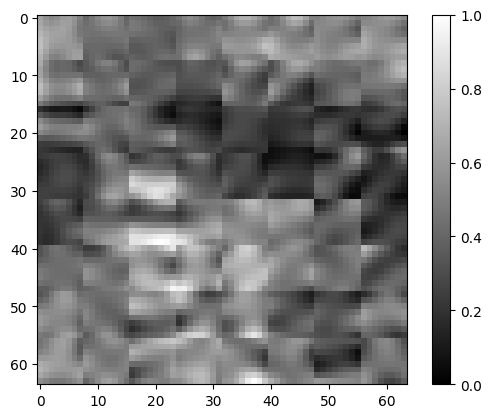

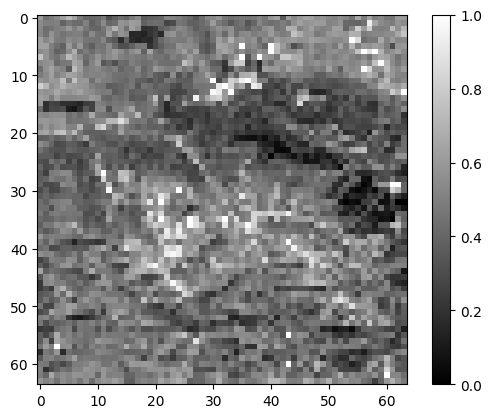

In [ ]:
print(preds[0, 0, :, :])

new_pred = preds.detach().numpy()[0, :, :, :].copy()
new_pred = np.moveaxis(new_pred, 0, -1)

new_pred = new_pred[:, :, 0]

new_img = batch[n].copy()
new_img = new_img[:, :, 0]

def rescale_for_visualization(image):
    """
    Rescales an image to the range [0, 1] for visualization.
    """
    min_val = np.min(image)
    max_val = np.max(image)
    return (image - min_val) / (max_val - min_val)

im1 = plt.imshow(rescale_for_visualization(new_pred), vmin=0, vmax=1,cmap='gray')
plt.axis("on")
plt.colorbar(im1, orientation='vertical')  # Add colorbar
plt.show()

# Assuming batch[n] is defined and hyperspectral_to_rgb is a function you've defined
# new_img = batch[n].copy()
# new_img = hyperspectral_to_rgb(new_img)

# Plotting the second image
im2 = plt.imshow(rescale_for_visualization(new_img), vmin=0, vmax=1,cmap='gray')
plt.axis("on")
plt.colorbar(im2, orientation='vertical')  # Add colorbar
plt.show()

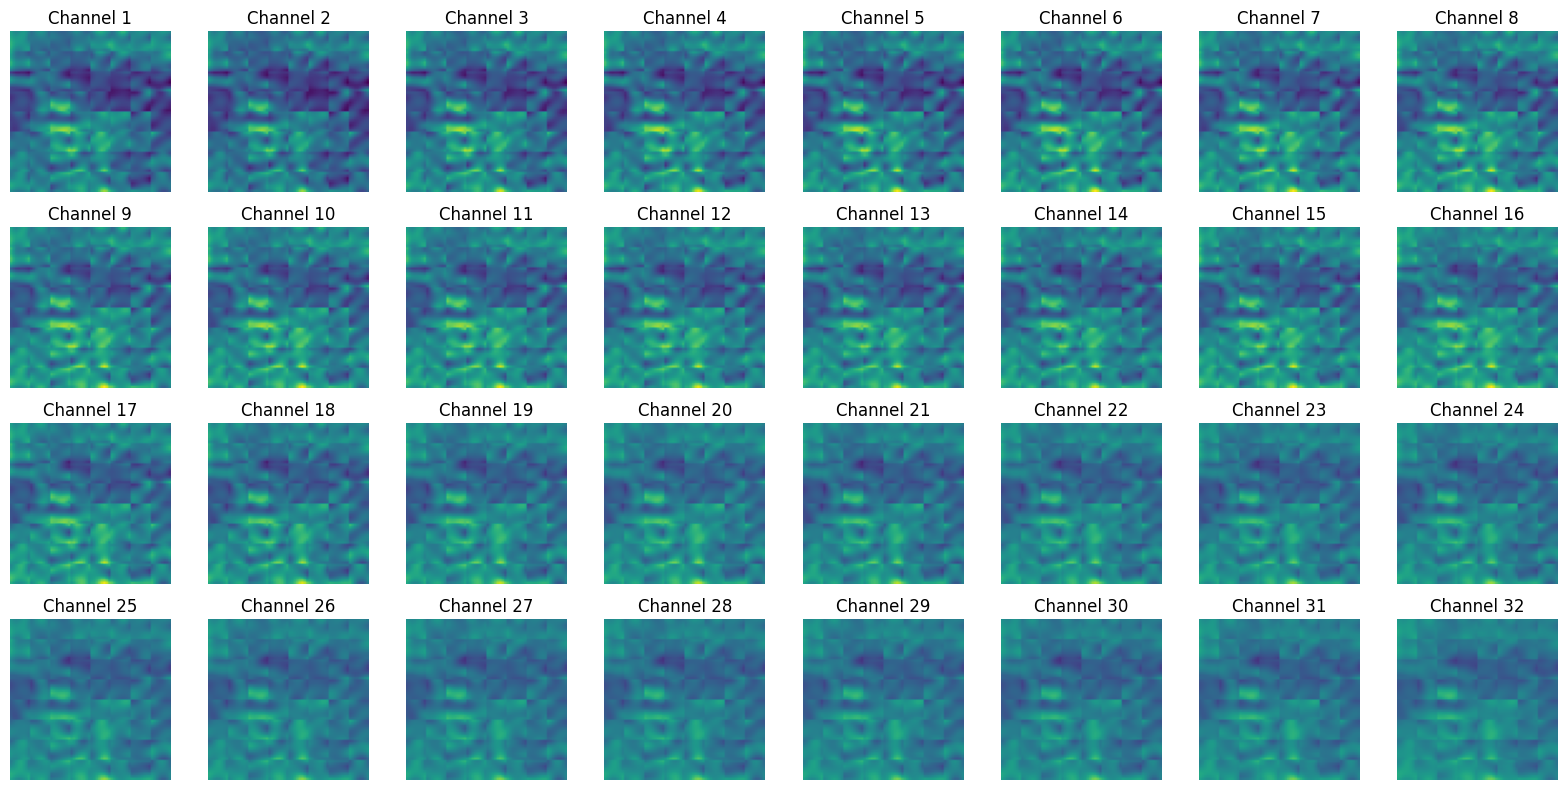

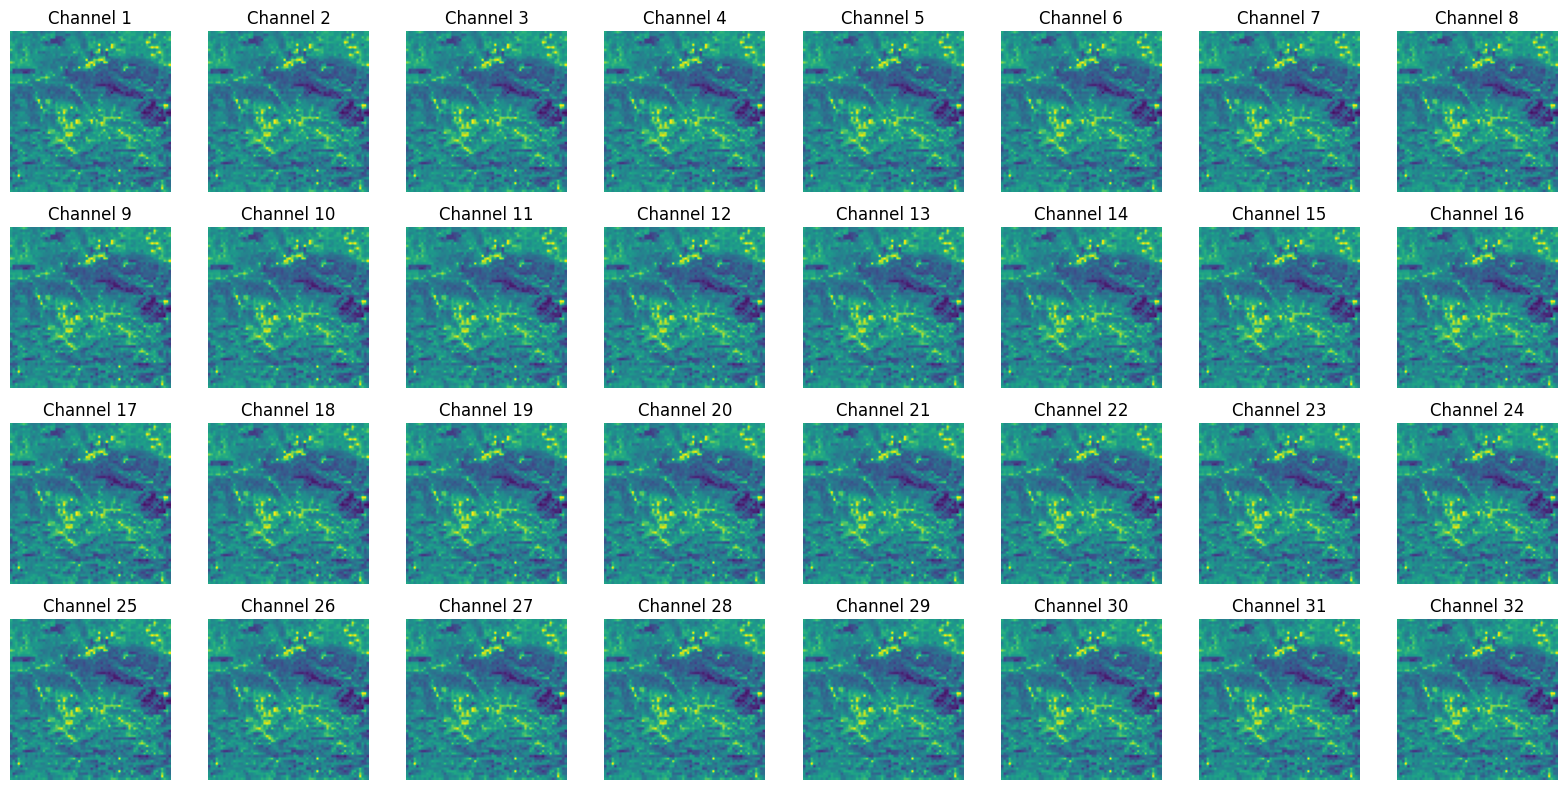

In [ ]:
# Create a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(16, 8))

# Loop over channels and plot each one
for i, ax in enumerate(axs.flat):
    ax.imshow(preds[0, i, ...].detach().numpy(), vmin=0, vmax=1)  # or choose another colormap
    ax.axis('off')

    ax.set_title(f'Channel {i + 1}')

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(4, 8, figsize=(16, 8))

# Loop over channels and plot each one
for i, ax in enumerate(axs.flat):
    ax.imshow(new_img, vmin=0, vmax=255)  # or choose another colormap
    ax.axis('off')

    ax.set_title(f'Channel {i + 1}')

plt.tight_layout()
plt.show()


torch.Size([1, 8, 65, 65])
torch.Size([1, 8, 65, 65])
torch.Size([1, 8, 65, 65])
torch.Size([1, 8, 65, 65])
torch.Size([1, 8, 65, 65])
torch.Size([1, 8, 65, 65])
torch.Size([1, 8, 65, 65])
torch.Size([1, 8, 65, 65])


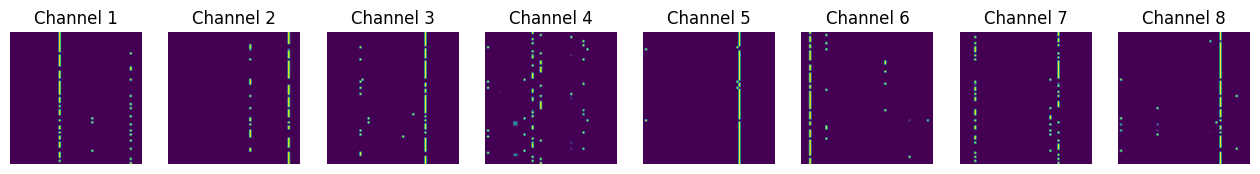

In [184]:
# Visualize attention
layer_idx = -1
head_idx = 0
fig, axs = plt.subplots(1, 8, figsize=(16, 8))
for i, ax in enumerate(axs.flat):
    attention_layer = attention[layer_idx]
    print(attention_layer.shape)

    ax.imshow(attention[layer_idx][0, i].cpu().detach().numpy())
    ax.axis('off')
    ax.set_title(f'Channel {i + 1}')

plt.show()




(1, 65, 64)


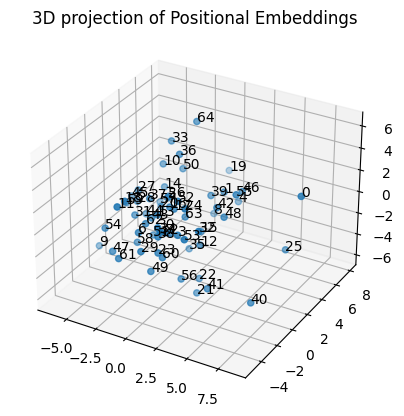

In [185]:


import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Assuming AE.vit.pos_embedding.detach().cpu().numpy() is your data
pos_embedding = AE.vit.pos_embedding.detach().cpu().numpy()

print(pos_embedding.shape)

# Dimensionality reduction to 3D
pca = PCA(n_components=3)
pos_embedding_3d = pca.fit_transform(pos_embedding[0])

# Create 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pos_embedding_3d[:, 0], pos_embedding_3d[:, 1], pos_embedding_3d[:, 2])

for i in range(pos_embedding_3d.shape[0]):
    ax.text(pos_embedding_3d[i, 0], pos_embedding_3d[i, 1], pos_embedding_3d[i, 2], str(i))

ax.set_title('3D projection of Positional Embeddings')
plt.show()


(1, 65, 64)


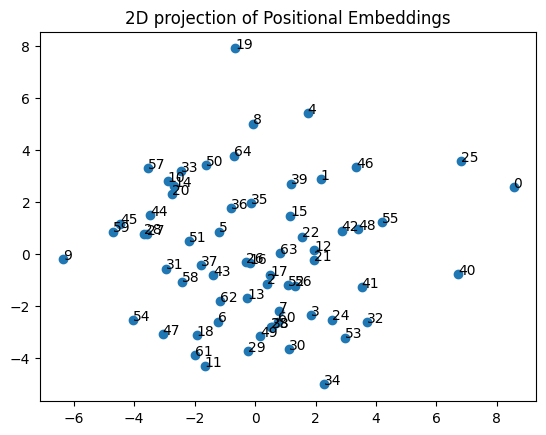

In [186]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming AE.vit.pos_embedding.detach().cpu().numpy() is your data
pos_embedding = AE.vit.pos_embedding.detach().cpu().numpy()

print(pos_embedding.shape)

# Dimensionality reduction to 2D
pca = PCA(n_components=2)
pos_embedding_2d = pca.fit_transform(pos_embedding[0])

# Create 2D scatter plot
fig, ax = plt.subplots()

ax.scatter(pos_embedding_2d[:, 0], pos_embedding_2d[:, 1])

for i in range(pos_embedding_2d.shape[0]):
    ax.text(pos_embedding_2d[i, 0], pos_embedding_2d[i, 1], str(i))

ax.set_title('2D projection of Positional Embeddings')
plt.show()


In [37]:
def compute_covariance_matrix(batch):
    batch_size = batch.shape[0]
    data = np.moveaxis(batch, -1, 1)
    data = data / 255
    mean_spectrum = np.mean(data, axis=(2, 3))

    # Subtract the mean spectrum from each pixel
    data_centered = data - mean_spectrum[:, :, np.newaxis, np.newaxis]

    # Reshape the data into a 2D array
    data_2d = data_centered.reshape((batch_size, -1, 32))

    # Compute the covariance matrix for each image in the batch
    covariance_matrices = []
    for i in range(batch_size):
        covariance_matrix = np.cov(data_2d[i].T)
        covariance_matrices.append(covariance_matrix)

    return np.array(covariance_matrices)


def combine_covariance_matrices(covariance_matrices):
    num_images = covariance_matrices.shape[0]
    combined_covariance_matrix = np.sum(covariance_matrices, axis=0) / num_images
    return combined_covariance_matrix


# Example usage

covariance_matrices = compute_covariance_matrix(batch)
combined_covariance_matrix = combine_covariance_matrices(covariance_matrices)
print(combined_covariance_matrix)


[[1.68728213e-06 9.81174978e-07 7.26383713e-07 ... 1.31827552e-07
  1.42886449e-07 1.36195546e-07]
 [9.81174978e-07 1.70156750e-06 9.70800032e-07 ... 1.28432375e-07
  1.50559297e-07 1.37294503e-07]
 [7.26383713e-07 9.70800032e-07 1.71013734e-06 ... 1.59762231e-07
  1.70551649e-07 1.45328043e-07]
 ...
 [1.31827552e-07 1.28432375e-07 1.59762231e-07 ... 1.68912129e-06
  9.64783981e-07 7.22038516e-07]
 [1.42886449e-07 1.50559297e-07 1.70551649e-07 ... 9.64783981e-07
  1.67571077e-06 9.72411236e-07]
 [1.36195546e-07 1.37294503e-07 1.45328043e-07 ... 7.22038516e-07
  9.72411236e-07 1.65851010e-06]]


In [38]:
data = batch[n].copy()
data = np.moveaxis(data, -1, 0)
data = data / 255
mean_spectrum = np.mean(data, axis=(0, 1))

# Subtract the mean spectrum from each pixel
data_centered = data - mean_spectrum

# Reshape the data into a 2D array
data_2d = data_centered.reshape((-1, 32))

# Compute the covariance matrix
covariance_matrix = np.cov(data_2d.T)

print(covariance_matrix)

[[2.40282896e-06 1.33414144e-06 1.16446371e-06 ... 4.96208126e-07
  4.14724816e-07 5.24518356e-08]
 [1.33414144e-06 2.51969975e-06 1.46119407e-06 ... 4.81310871e-07
  4.33573806e-07 1.63247839e-07]
 [1.16446371e-06 1.46119407e-06 2.63735368e-06 ... 8.19624340e-07
  7.70860976e-07 3.65732056e-07]
 ...
 [4.96208126e-07 4.81310871e-07 8.19624340e-07 ... 2.48476389e-06
  1.31404024e-06 8.78963513e-07]
 [4.14724816e-07 4.33573806e-07 7.70860976e-07 ... 1.31404024e-06
  2.34209524e-06 1.07388930e-06]
 [5.24518356e-08 1.63247839e-07 3.65732056e-07 ... 8.78963513e-07
  1.07388930e-06 2.22553151e-06]]


(32, 32)


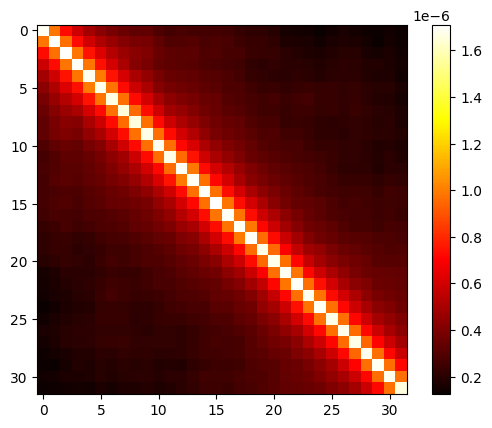

In [39]:
print(combined_covariance_matrix.shape)
plt.imshow(combined_covariance_matrix, cmap='hot')
plt.colorbar()
plt.show()

In [63]:

def linear_spectral_unmixing(hsi_data, endmembers):
    """
    Perform Linear Spectral Unmixing on Hyperspectral Image Data.
    
    Parameters:
    hsi_data (numpy array): Hyperspectral image data of shape (rows, cols, bands).
    endmembers (numpy array): Endmember signatures of shape (num_endmembers, bands).
    
    Returns:
    numpy array: Abundance maps of shape (rows, cols, num_endmembers).
    """
    # Get dimensions of the hyperspectral image data
    rows, cols, bands = hsi_data.shape

    # Ensure endmembers matrix is oriented correctly (bands, num_endmembers)
    if endmembers.shape[1] != bands:
        endmembers = endmembers.T

    num_endmembers = endmembers.shape[0]

    # Reshape the hyperspectral image data to 2D array (pixels, bands)
    hsi_data_2d = hsi_data.reshape(-1, bands)

    # Calculate the pseudo-inverse of the endmember matrix
    endmembers_pinv = np.linalg.pinv(endmembers)

    # Perform the unmixing
    abundance_maps_2d = np.dot(hsi_data_2d, endmembers_pinv)

    # Apply constraints (ensure non-negativity and sum-to-one)
    abundance_maps_2d = np.clip(abundance_maps_2d, 0, None)  # Non-negativity
    sum_abundance = np.sum(abundance_maps_2d, axis=1, keepdims=True)
    abundance_maps_2d = abundance_maps_2d / sum_abundance  # Sum-to-one

    # Reshape the abundance maps to 3D array (rows, cols, num_endmembers)
    abundance_maps = abundance_maps_2d.reshape(rows, cols, num_endmembers)

    return abundance_maps


print(data.shape)
print(endmembers.shape)
# Usage:
# Assume hsi_data is your hyperspectral image data and endmembers is your endmember signatures matrix
abundance_maps = linear_spectral_unmixing(data, endmembers)


(32, 512, 512)
(4, 512)


/tmp/ipykernel_1487/1479502286.py:33: RuntimeWarning: invalid value encountered in divide
  abundance_maps_2d = abundance_maps_2d / sum_abundance  # Sum-to-one


(32, 512, 4)


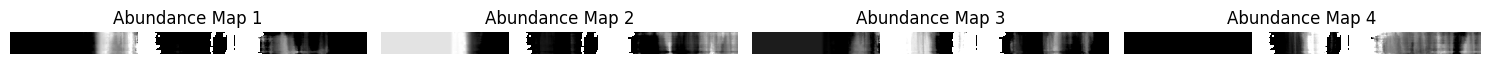

In [66]:
print(abundance_maps.shape)


def visualize_abundance_maps(abundance_maps):
    num_endmembers = abundance_maps.shape[-1]
    fig, axs = plt.subplots(1, num_endmembers, figsize=(15, 5))

    for i in range(num_endmembers):
        ax = axs[i]
        abundance_map = abundance_maps[:, :, i]
        ax.imshow(abundance_map, cmap='gray')
        ax.set_title(f'Abundance Map {i + 1}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


# Usage:
# Assume abundance_maps is the output from your linear spectral unmixing function
visualize_abundance_maps(abundance_maps)


In [43]:
%pip install spectral


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 31.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [58]:

from sklearn.decomposition import FastICA

data_new = data.copy()
# Assuming hsi_data is your hyperspectral image data
# Reshape the data to 2D array
data_2d = data_new.reshape(-1, data_new.shape[-1])

# Perform ICA
ica = FastICA(n_components=4)  # Assuming 4 endmembers
S_ = ica.fit_transform(data_2d)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix, which contains the endmembers

# Each column of A_ is an endmember
endmembers = A_.T


In [54]:
print(endmembers.shape)

(4, 512)
